In [37]:
import os
from PIL import Image
from pathlib import Path
from functools import partial

import lightning as L
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import VisionDataset, ImageFolder
from torchvision.models import get_weight
import pandas as pd
import numpy as np
import skimage as ski
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

from src.cnn_model.utils import CNNClassifier

In [2]:
DATASET_PATH = "./datasets/fog-prediction"

In [3]:
df = pd.read_csv(f"{DATASET_PATH}/ImageSummary.csv")
df.head()

,dateTime,name,meanEdge,year,month,day,hour,FS261 [m],TMM261 [m],FS260 [m],medianMOR [m]
0,1/10/2015 6:00,Meetterrein_20151001_0600.jpg,0.168987,2015,10,1,6,5840.0,4440.0,5400.0,5400.0
1,1/10/2015 6:10,Meetterrein_20151001_0610.jpg,0.208750,2015,10,1,6,6140.0,4650.0,6360.0,6140.0
2,1/10/2015 6:20,Meetterrein_20151001_0620.jpg,0.236262,2015,10,1,6,8210.0,6100.0,7200.0,7200.0
3,1/10/2015 6:30,Meetterrein_20151001_0630.jpg,0.252646,2015,10,1,6,8480.0,6460.0,8070.0,8070.0
4,1/10/2015 6:40,Meetterrein_20151001_0640.jpg,0.246404,2015,10,1,6,9650.0,7140.0,9210.0,9210.0


In [4]:
def check_if_exists(item, file_name_column: str):
    return Path.exists(
        Path(f"{DATASET_PATH}/{item.year}{item.month:02}/{item[file_name_column]}")
    )

df['exists'] = df.apply(partial(check_if_exists, file_name_column="name"), axis=1)
df.head()

,dateTime,name,meanEdge,year,month,day,hour,FS261 [m],TMM261 [m],FS260 [m],medianMOR [m],exists
0,1/10/2015 6:00,Meetterrein_20151001_0600.jpg,0.168987,2015,10,1,6,5840.0,4440.0,5400.0,5400.0,True
1,1/10/2015 6:10,Meetterrein_20151001_0610.jpg,0.208750,2015,10,1,6,6140.0,4650.0,6360.0,6140.0,True
2,1/10/2015 6:20,Meetterrein_20151001_0620.jpg,0.236262,2015,10,1,6,8210.0,6100.0,7200.0,7200.0,True
3,1/10/2015 6:30,Meetterrein_20151001_0630.jpg,0.252646,2015,10,1,6,8480.0,6460.0,8070.0,8070.0,True
4,1/10/2015 6:40,Meetterrein_20151001_0640.jpg,0.246404,2015,10,1,6,9650.0,7140.0,9210.0,9210.0,True


In [5]:
def load_image(path: str):
    img = ski.io.imread(path)
    if img.ndim == 2:  # Handle grayscale
        img = ski.color.gray2rgb(img)
    if img.shape[-1] == 4:  # Handle RGBA
        img = ski.color.rgba2rgb(img)
    img = ski.util.img_as_ubyte(img)
    img = img.squeeze()
    
    return Image.fromarray(img)


class FogPredictionDataset(VisionDataset):
    def __init__(self,
            root: str,
            csv_file: str,
            file_column: str = "name",
            target_column: str = "medianMOR [m]",
            loader: callable = load_image,
            transforms = None, 
            transform = None, 
            target_transform = None
    ):
        root = Path(root)
        df = pd.read_csv(f"{root}/{csv_file}")
        df['exists'] = df.apply(partial(check_if_exists, file_name_column=file_column), axis=1)
        df = df[df['exists'] == True]
        samples = []
        for _, item in df.iterrows():
            samples.append(
                (root / f"{item.year}{item.month:02}" / item[file_column], item[target_column])
            )
        self.samples = samples
        self.loader = loader
        super().__init__(root, transforms, transform, target_transform)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
        
        return sample, target

In [6]:
ds = FogPredictionDataset(
    root="./datasets/fog-prediction",
    csv_file="ImageSummary.csv",
)
ds.__getitem__(0)

(<PIL.Image.Image image mode=RGB size=768x576>, 5400.0)

In [7]:
model = CNNClassifier.load_from_checkpoint(
    './runs/classify/CNN/EfficientNet_B1-combined/version_1/epoch=7-val_loss=0.04-val_f1=0.98.ckpt'
)

In [8]:
trainer = L.Trainer()

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [26]:
results = trainer.predict(
    model=model,
    dataloaders=DataLoader(
        dataset=FogPredictionDataset(
            DATASET_PATH,
            "ImageSummary.csv",
            transform=get_weight(model.weights).transforms()
        ),
        batch_size=32,
        shuffle=False,
        num_workers=11
    )
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 45/45 [00:03<00:00, 12.73it/s]


In [10]:
df = df[df['exists'] == True]

<Axes: xlabel='medianMOR [m]', ylabel='random_y'>

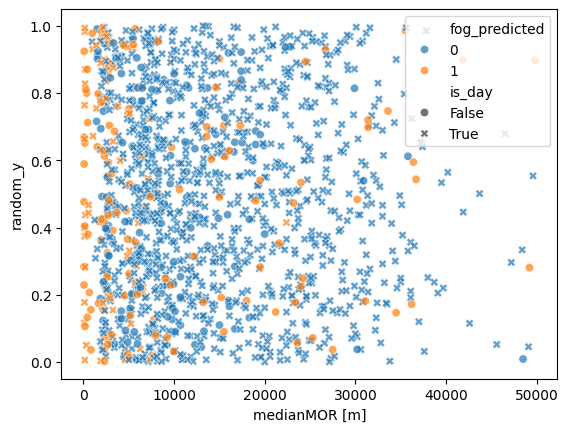

In [34]:
predicted = torch.vstack(results).argmax(dim=1)

# Plot visibility against predicted class
df['fog_predicted'] = predicted
df['random_y'] = np.random.random(len(df))
df['is_day'] = df['hour'].apply(lambda hour: 6 < hour < 20)

sns.scatterplot(
    df,
    x='medianMOR [m]',
    y='random_y',
    hue='fog_predicted',
    style='is_day',
    alpha=0.7
)

In [36]:
df['fog'] = (df['medianMOR [m]'] < 1000).astype(int)

df.head()

,dateTime,name,meanEdge,year,month,day,hour,FS261 [m],TMM261 [m],FS260 [m],medianMOR [m],exists,fog_predicted,random_y,is_day,fog
0,1/10/2015 6:00,Meetterrein_20151001_0600.jpg,0.168987,2015,10,1,6,5840.0,4440.0,5400.0,5400.0,True,0,0.778328,False,0
1,1/10/2015 6:10,Meetterrein_20151001_0610.jpg,0.208750,2015,10,1,6,6140.0,4650.0,6360.0,6140.0,True,0,0.599577,False,0
2,1/10/2015 6:20,Meetterrein_20151001_0620.jpg,0.236262,2015,10,1,6,8210.0,6100.0,7200.0,7200.0,True,0,0.691062,False,0
3,1/10/2015 6:30,Meetterrein_20151001_0630.jpg,0.252646,2015,10,1,6,8480.0,6460.0,8070.0,8070.0,True,0,0.806466,False,0
4,1/10/2015 6:40,Meetterrein_20151001_0640.jpg,0.246404,2015,10,1,6,9650.0,7140.0,9210.0,9210.0,True,0,0.050924,False,0


In [39]:
acc = metrics.accuracy_score(
    df['fog'],
    df['fog_predicted']    
)
df_day = df[df['is_day'] == True]
df_night = df[df['is_day'] == False]
acc_day = metrics.accuracy_score(
    df_day['fog'],
    df_day['fog_predicted']    
)
acc_night = metrics.accuracy_score(
    df_night['fog'],
    df_night['fog_predicted']    
)
print(f"Accuracy: {acc:.4f}")
print(f"Accuracy day: {acc_day:.4f}")
print(f"Accuracy night: {acc_night:.4f}")

Accuracy: 0.8887
Accuracy day: 0.9529
Accuracy night: 0.6000
